<a href="https://colab.research.google.com/github/yordanglez/complexity-stability-feature-selection/blob/main/complexity_stability_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install problexity arff


In [4]:
import problexity as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV, LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.utils import resample
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import jaccard_score
import pandas as pd
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning,DataConversionWarning
import pandas as pd
import math


warnings.filterwarnings("ignore")


# 1. Defining our datasets for experiments

**Ant Dataset**

The Ant dataset comes from the Apache Ant project, which is a widely used software build tool developed in Java. The Apache Ant project is part of the Apache Software Foundation and has been a reference in many studies on software quality and defects. It is frequently used in defect prediction studies due to its extensive use in the software community and because it contains detailed information on code metrics and defects across historical versions of the project.

**Camel Dataset**

Apache Camel is a software integration framework for Java, developed as part of the Apache Software Foundation. It is used in integration systems to manage and process data between different applications. It is another set of software metrics frequently used in defect prediction studies. It contains information on defects and software quality metrics from the early versions of the project.


**Velocity Dataset**

Apache Velocity is a template engine for Java that allows developers to use templates to generate source code or content dynamically. It is commonly used to separate content from presentation in web applications. It provides software quality metrics and defects found in that version of the template engine.

**JEdit Dataset**

JEdit is a text editor and development environment for programmers, written in Java. It is a popular tool among developers as it offers many advanced features for text editing and code manipulation. This dataset is based on the structure of classes and modules in JEdit and contains code metrics that allow analyzing the quality of the code and predicting defects.




In [80]:
def extract_features_and_target(df, target_column, offset, limit):
    df['defects'] = df['bug'] > 0
    df = df.drop(columns=['name', 'version', 'name.1', 'bug'], axis=1)

    df.replace('?', np.nan, inplace=True)
    df.replace('-', np.nan, inplace=True)
    df.dropna(inplace=True)

    df_with_defects = df[df['defects'] == True]
    df_without_defects = df[df['defects'] == False]

    num_with_defects = min(len(df_with_defects), limit // 2)

    with_defects_sub = df_with_defects.sample(n=num_with_defects, random_state=42)

    num_without_defects = min(len(df_without_defects), limit - num_with_defects)

    without_defects_sub = df_without_defects.sample(n=num_without_defects, random_state=42)

    df_sub = pd.concat([with_defects_sub, without_defects_sub]).sample(frac=1, random_state=42).reset_index(drop=True)

    if target_column not in df.columns:
        raise ValueError(f"La columna '{target_column}' no existe en el DataFrame.")

    X = df_sub.drop(columns=[target_column])
    y = df_sub[target_column]

    return X, y
ant = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/ant-1.7.csv')
camel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/camel-1.6.csv')
velocity = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/velocity-1.6.csv')
jedit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/jedit-3.2.csv')
xalan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/xalan-2.4.csv')
xerces = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/xerces-1.3.csv')
data_arc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/data_arc.csv')
data_ivy = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/data_ivy-2.0.csv')
data_redaktor = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/data_redaktor.csv')
synapse = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/synapse-1.2.csv')
poi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/poi-2.0.csv')
lucene = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/DATASET/lucene-2.0.csv')



datasets = {
    'Ant': extract_features_and_target(ant, 'defects', 0, 50),
    'Camel': extract_features_and_target(camel, 'defects',0, 500),
    'Velocity': extract_features_and_target(velocity, 'defects', 0, 150),
    'Jedit': extract_features_and_target(jedit, 'defects', 0, 100),
    'Xalan': extract_features_and_target(xalan, 'defects', 0, 300),
    'Xerces': extract_features_and_target(xerces, 'defects', 0, 400),
    'DataArc': extract_features_and_target(ant, 'defects', 0, 500),
    'DataIvy': extract_features_and_target(ant, 'defects', 0, 700),
    'DataRedaktor': extract_features_and_target(ant, 'defects', 0, 600),
    'Synapse': extract_features_and_target(ant, 'defects', 0, 400),
    'POI': extract_features_and_target(ant, 'defects', 0, 200),
    'Lucene': extract_features_and_target(ant, 'defects', 0, 100)
}

# What features will we use for experiments?

The features we are using for the experiment come from software metrics that are commonly used in the field of software engineering to assess the quality of the code and predict potential defects. These metrics provide insights into different aspects of the code's structure, such as its complexity, cohesion, and coupling. These factors are important because higher complexity, lower cohesion, and higher coupling are often associated with more defects and maintainability issues in software.

## Overview of the Features:

**wmc**: The weighted methods per class. This is calculated by summing the cyclomatic complexity of all methods in a class. Indicates how complex a class is in terms of the number of methods and their individual complexity. Classes with high WMC can be harder to understand and more prone to errors.

**dit**: Depth of inheritance tree. Measures the number of inheritance levels from a class to the root of the inheritance tree. The deeper the inheritance tree, the harder it may be to understand the behavior of a class, as it is influenced by multiple levels of inheritance. This can increase the likelihood of errors.

**noc**: Number of children. Measures how many classes inherit from a given class. A high number of children indicates that the class is highly reused, which can be good for code reuse but can also increase the likelihood of defects if the base class contains errors or is difficult to maintain.

**cbo**: Coupling between objects. Measures the number of external classes a given class is coupled to (or dependent on). High coupling means that the class depends on many other classes, which can increase complexity and the likelihood of defects.

**rfc**: Response for a class. Measures the number of methods that can be invoked in response to a message received by a class. A high RFC value indicates that the class has many ways to react to different inputs, which can make it more error-prone due to its complexity.

**lcom**: Lack of cohesion of methods. Measures how related the methods in a class are based on the instance variables they share. Low cohesion indicates that the class has too many unrelated responsibilities, making it harder to understand and more prone to defects.

**ca**: Afferent couplings. Measures how many classes depend on a given class. If many classes depend on one class, a defect in the central class can have severe consequences throughout the system.

**ce**: Efferent couplings. Measures how many classes a given class depends on. A high CE value suggests that the class is highly coupled to others, making it more complex and difficult to maintain.

**npm**: Number of public methods. A high number of public methods may indicate a complex API or a class that exposes too much functionality, increasing its complexity.

**lcom3**: Lack of cohesion of methods, version 3. Another measure of the lack of cohesion among a class’s methods. Similar to LCOM, this metric measures how related the responsibilities of a class are.

**loc**: Lines of code. The total number of lines of code in a class. Classes with many lines of code tend to be more complex, harder to maintain, and more prone to errors.

**dam**: Data access metric. Measures the percentage of instance variables that are private or protected (encapsulated). A high DAM value indicates good encapsulation, which is generally desirable for reducing the risk of defects.

**moa**: Measure of aggregation. Measures the number of objects used as attributes within a class. A high MOA value indicates strong aggregation, meaning the class has many dependencies, which increases the risk of defects.

**mfa**: Measure of functional abstraction. Measures the percentage of methods that are inherited. A high MFA value indicates that the class is reusing methods from its parent classes, which can be beneficial for code reuse but may make its behavior harder to predict.

**cam**: Cohesion among methods. Measures cohesion among methods. High cohesion is desirable because it means that the methods in the class focus on a specific task.

**ic**: Inheritance coupling. Measures how many classes are coupled to others through inheritance. A high value indicates strong dependence through inheritance, which can make the system harder to maintain.

**cbm**: Coupling between methods. Measures the number of dependencies between methods within a class. A high value indicates that the methods are tightly coupled, which can make the system harder to modify or extend.

**amc**: Average method complexity. Measures the average cyclomatic complexity of the methods within a class. High complexity in individual methods suggests that they are harder to understand and maintain.

**max_cc**: Maximum cyclomatic complexity. Measures the highest cyclomatic complexity value among all methods in a class. Indicates how complex the most complicated methods in a class are.

**avg_cc**: Average cyclomatic complexity. Measures the average cyclomatic complexity of all the methods in a class. A high average value suggests that the class, as a whole, is harder to understand, increasing the likelihood of errors.

**bug**: A binary indicator that shows whether a class has a bug or defect. This is the target variable in defect prediction models. 1 indicates the class has at least one defect, while 0 means the class is defect-free.



# The following shows the distribution of defects and non-defects across our datasets.

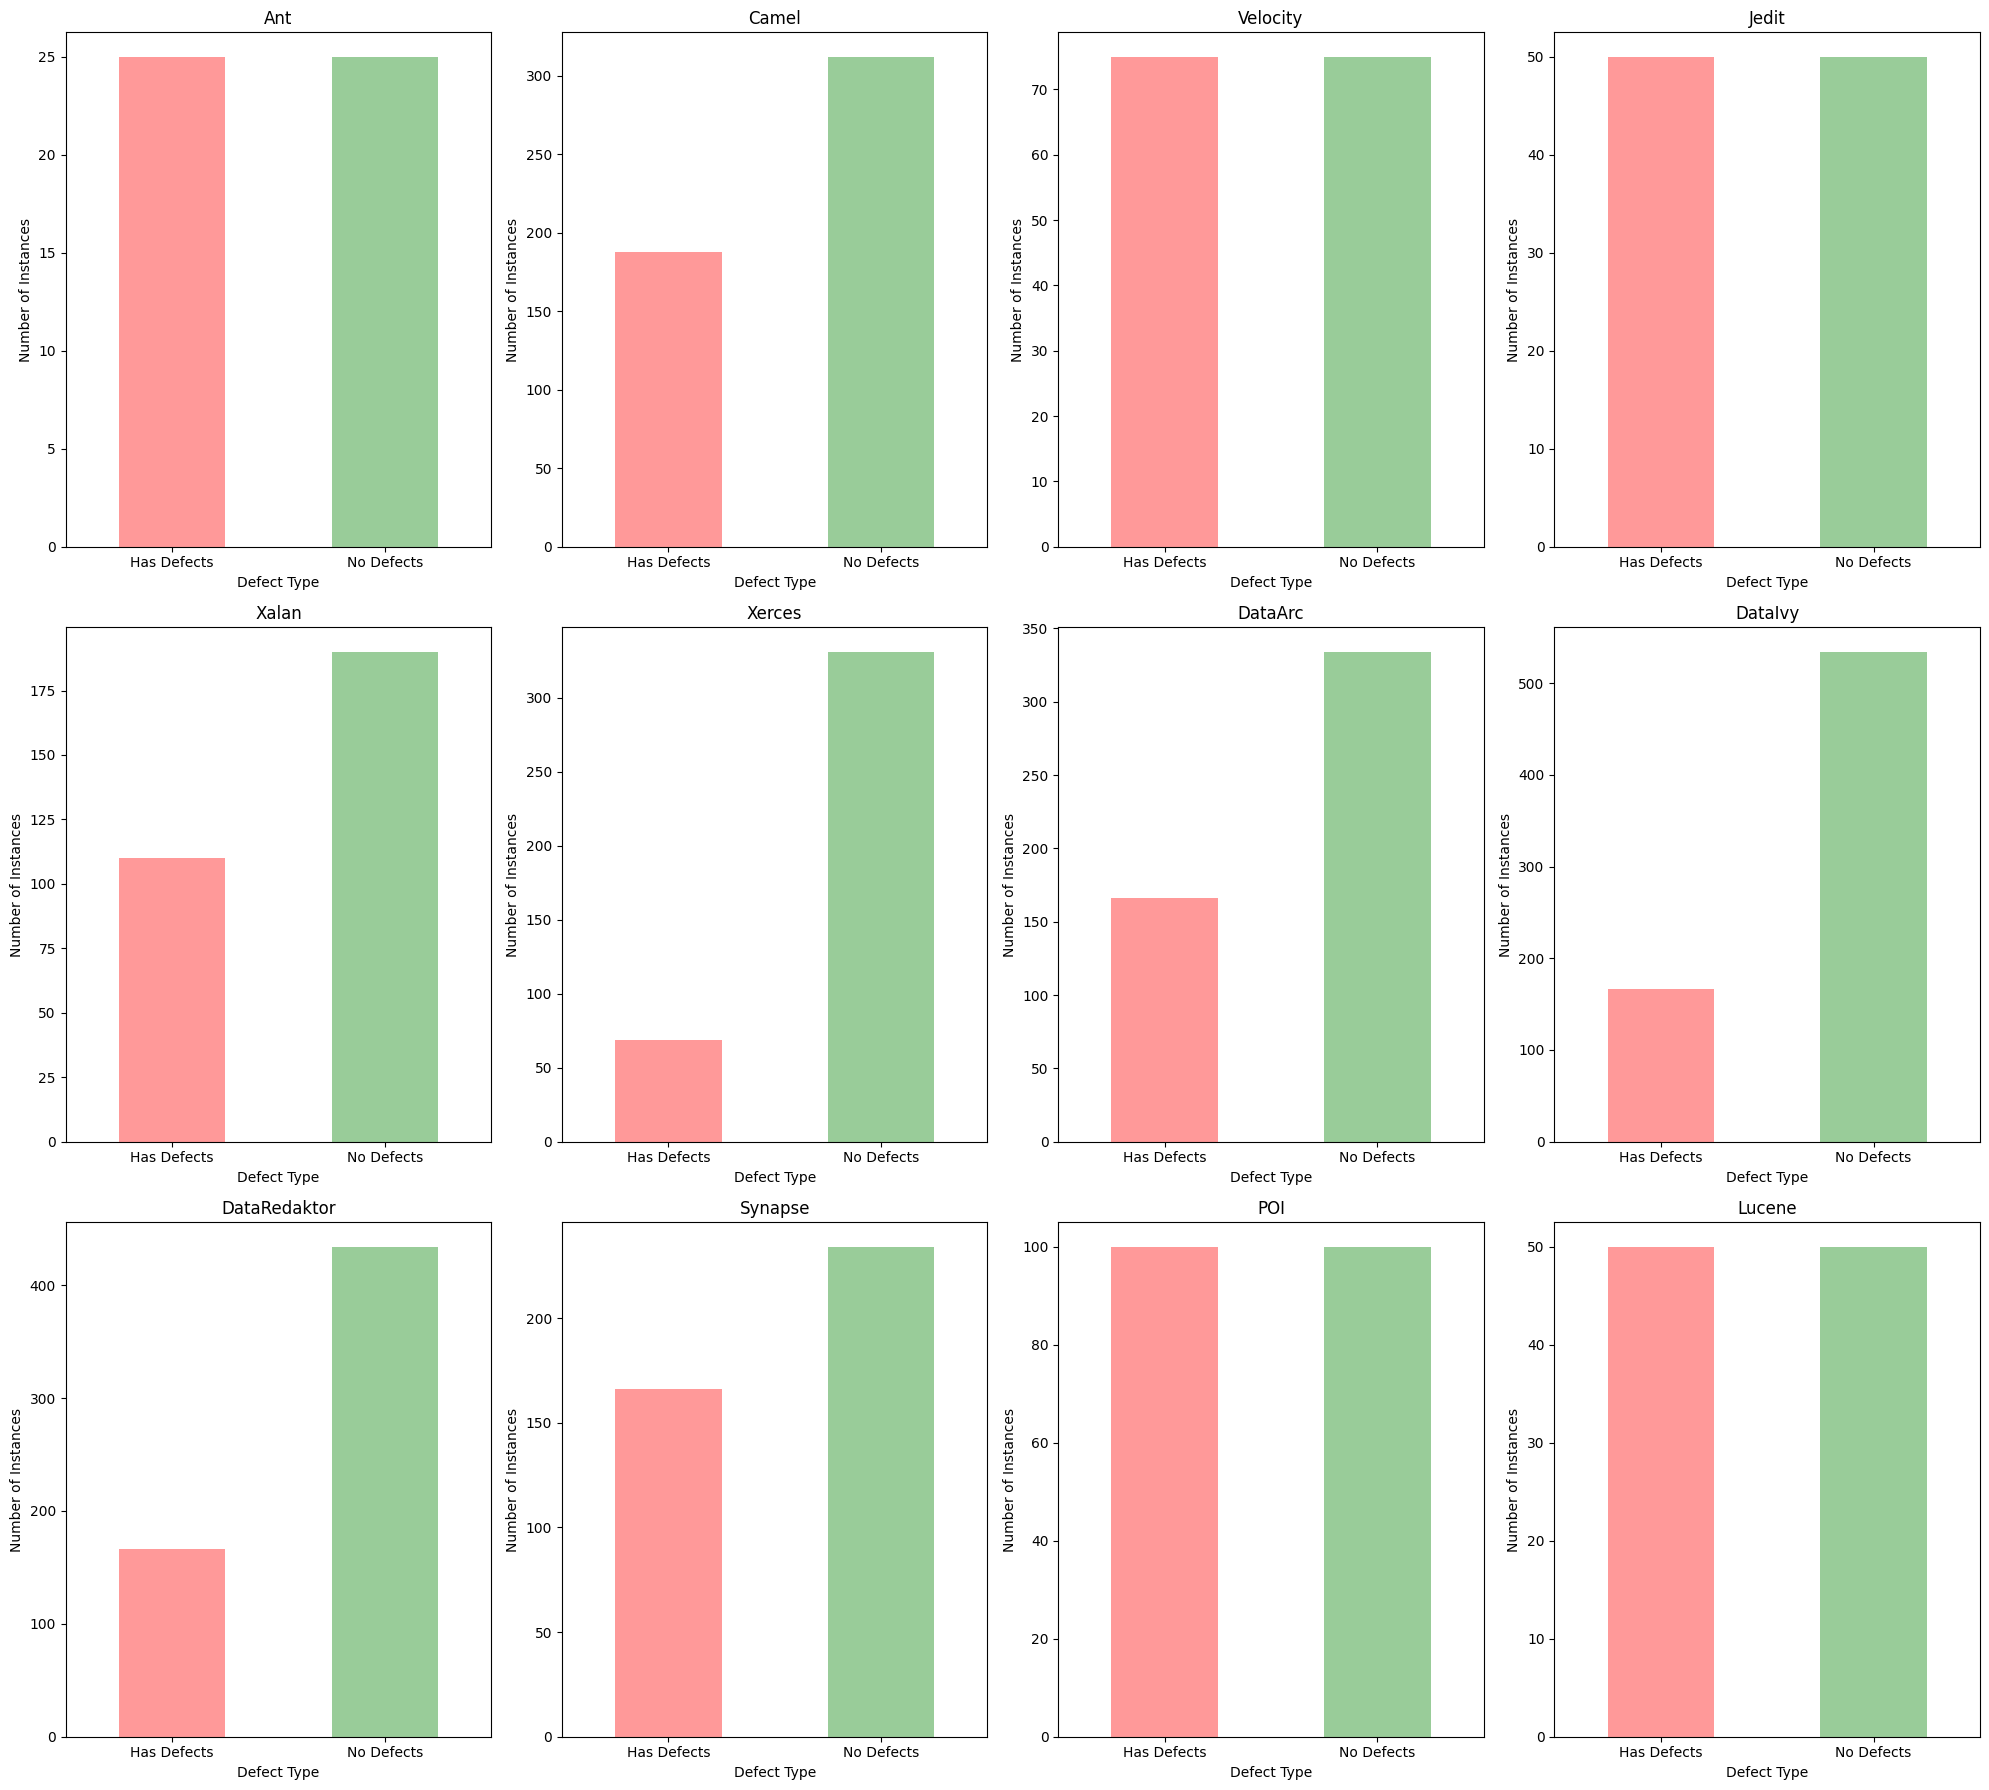

In [81]:
defect_data = []
for dataset_name, (X, y) in datasets.items():
    defect_count = y.value_counts()
    has_defects = defect_count.get(True, defect_count.get(1, 0))
    no_defects = defect_count.get(False, defect_count.get(0, 0))

    defect_data.append({
        'Dataset': dataset_name,
        'Has Defects': has_defects,
        'No Defects': no_defects
    })

df_defects = pd.DataFrame(defect_data)


color_has_defects = '#FF9999'
color_no_defects = '#99CC99'

n_datasets = len(df_defects)
n_cols = 4
n_rows = math.ceil(n_datasets / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))

axes = axes.flatten()

for i, (dataset_name, row) in enumerate(df_defects.iterrows()):
    row_data = pd.DataFrame({
        'Defect Type': ['Has Defects', 'No Defects'],
        'Count': [row['Has Defects'], row['No Defects']]
    })

    bars = row_data.plot(kind='bar', x='Defect Type', y='Count', stacked=True, ax=axes[i], color=[color_has_defects, color_no_defects], legend=False)
    axes[i].set_title(row['Dataset'])
    axes[i].set_ylabel('Number of Instances')
    axes[i].set_xticklabels(['Has Defects', 'No Defects'], rotation=0)


if n_datasets % n_cols != 0:
    for j in range(n_datasets, n_rows * n_cols):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#About Complexity

# 2. Calculate the complexity of the entire dataset

We calculate and visualize the complexity of various datasets. The process start by normalizing the features of each dataset and then using a complexity calculator to generate a report that includes various complexity metrics and an overall complexity score for each dataset.

(50, 20)
Complexity of dataset Ant: 0.3160
Complexity of dataset Camel: 0.4400
Complexity of dataset Velocity: 0.3900
Complexity of dataset Jedit: 0.3460
Complexity of dataset Xalan: 0.4110
Complexity of dataset Xerces: 0.3900
Complexity of dataset DataArc: 0.4000
Complexity of dataset DataIvy: 0.4070
Complexity of dataset DataRedaktor: 0.4050
Complexity of dataset Synapse: 0.3970
Complexity of dataset POI: 0.3890
Complexity of dataset Lucene: 0.3410


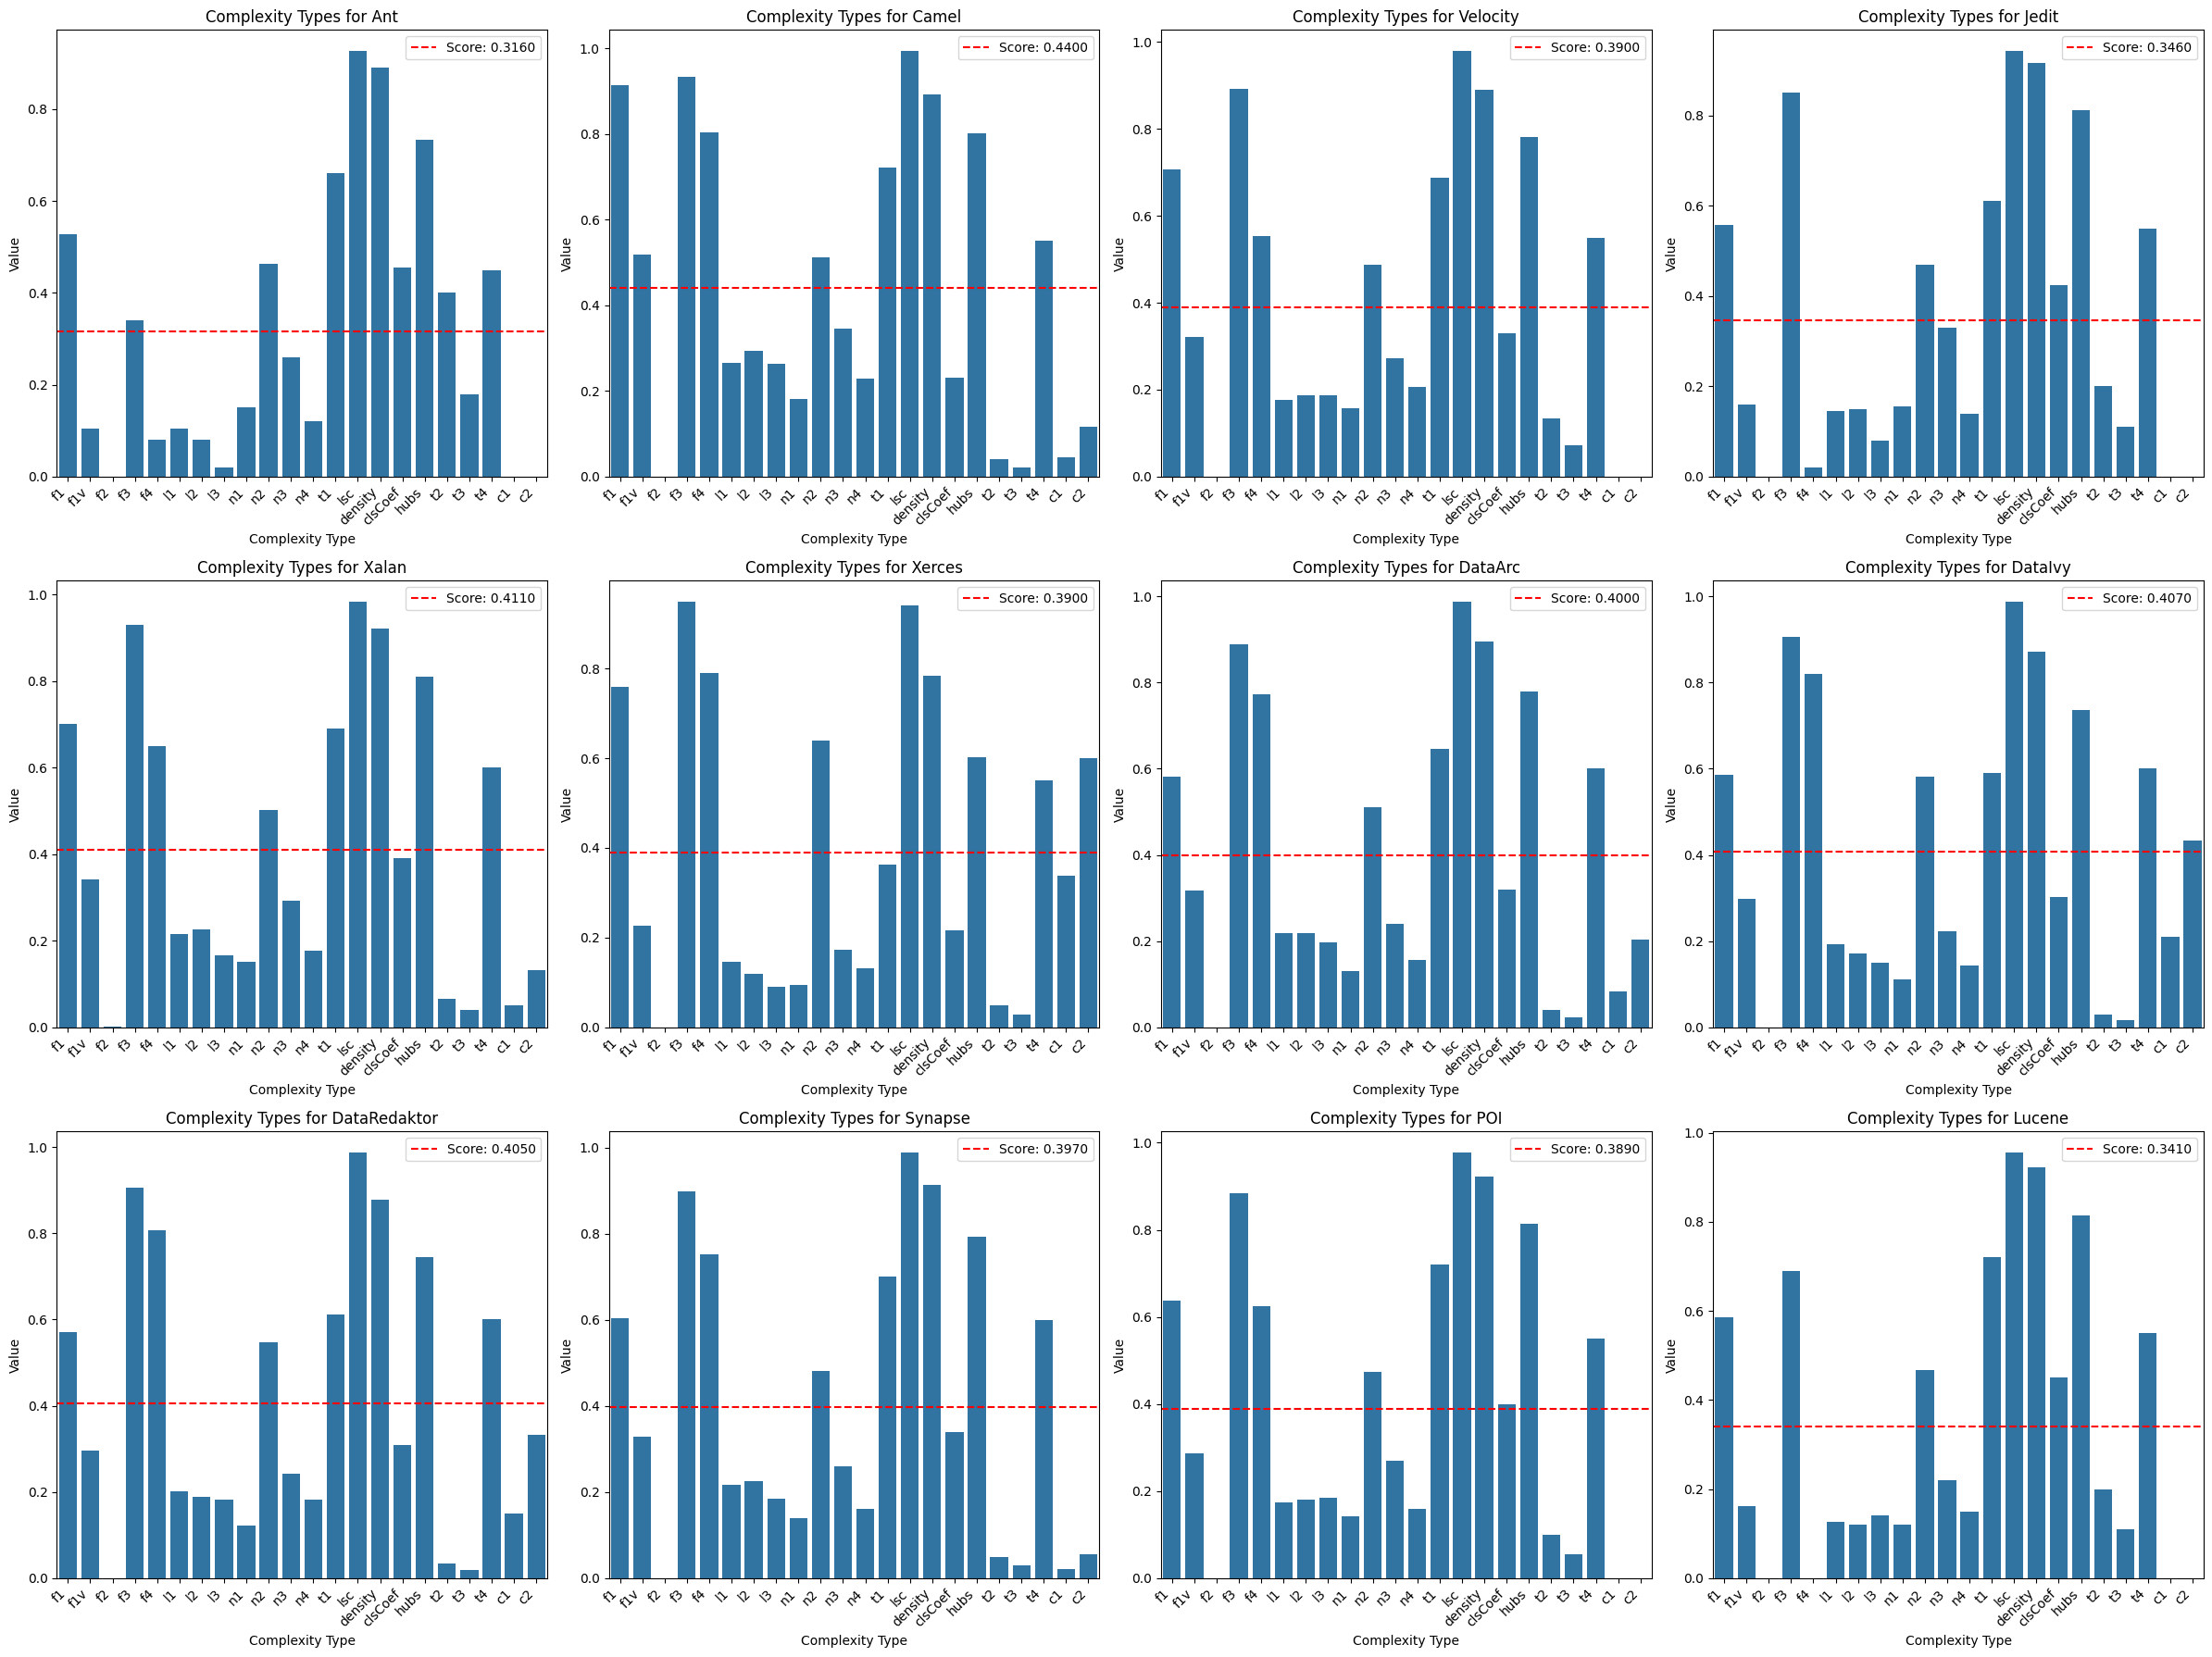

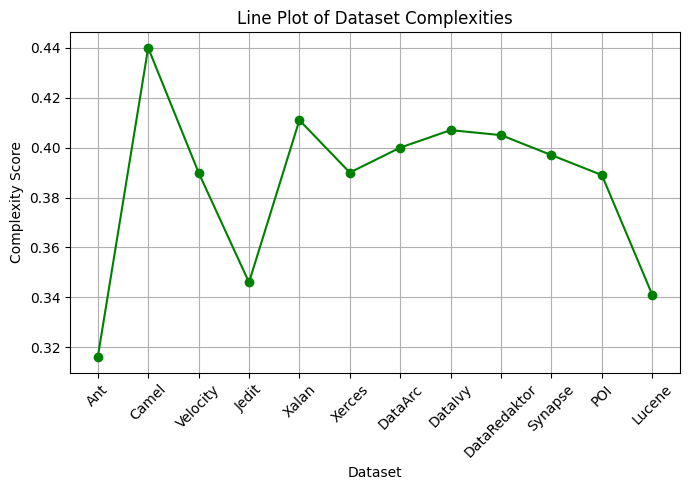

In [82]:
dataset_complexities = {}
for dataset_name, (X, y) in datasets.items():
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    cc = px.ComplexityCalculator(multiclass_strategy='ova')
    if dataset_name == 'Ant':
      print(X_scaled.shape)
    cc.fit(X_scaled, y)
    report = cc.report()
    complexity = report['score']
    dataset_complexities[dataset_name] = report
    print(f'Complexity of dataset {dataset_name}: {complexity:.4f}')


max_graphs_per_row = 4

n_datasets = len(dataset_complexities)
n_rows = math.ceil(n_datasets / max_graphs_per_row)


fig, axes = plt.subplots(n_rows, min(n_datasets, max_graphs_per_row),
                         figsize=(6 * min(n_datasets, max_graphs_per_row), 6 * n_rows))

if n_rows == 1:
    axes = [axes]

for i, (dataset_name, report) in enumerate(dataset_complexities.items()):
    complexity_types = list(report['complexities'].keys())
    complexity_values = list(report['complexities'].values())
    overall_score = report['score']

    df = pd.DataFrame({
        'Complexity Type': complexity_types,
        'Value': complexity_values
    })

    row = i // max_graphs_per_row
    col = i % max_graphs_per_row

    sns.barplot(x='Complexity Type', y='Value', data=df, ax=axes[row][col] if n_rows > 1 else axes[col])

    ax = axes[row][col] if n_rows > 1 else axes[col]
    ax.axhline(y=overall_score, color='red', linestyle='--', label=f'Score: {overall_score:.4f}')
    ax.set_xlabel('Complexity Type')
    ax.set_ylabel('Value')
    ax.set_title(f'Complexity Types for {dataset_name}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend()

plt.tight_layout()
plt.show()

dataset_names = list(dataset_complexities.keys())
complexities = [report['score'] for report in dataset_complexities.values()]

plt.figure(figsize=(7, 5))
plt.plot(dataset_names, complexities, marker='o', linestyle='-', color='green')
plt.xlabel('Dataset')
plt.ylabel('Complexity Score')
plt.title('Line Plot of Dataset Complexities')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. Define the feature selection models

In this section, we define the feature selection algorithms that will be used in our experiments

In [85]:

models = {
    'LASSO': Lasso(alpha=0.01),
    'LassoCV': LassoCV(alphas=[0.01, 0.1, 1, 10], cv=5),
    # 'Ridge': Ridge(alpha=0.01),
    # 'RidgeCV': RidgeCV(alphas=[0.01, 0.1, 1, 10], cv=5),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
    'ElasticNetCV': ElasticNetCV(alphas=[0.01, 0.1, 1, 10], l1_ratio=[0.1, 0.5, 0.9], cv=5),
    "SelectKBest": SelectKBest(score_func=f_classif),
    # "RandomForest": RandomForestClassifier(n_estimators=100),
    'RFE (LogisticRegression)': RFE(estimator=LogisticRegression(),
    n_features_to_select=10),
    # 'RFE (LogisticRegressionCV)': RFE(estimator=LogisticRegressionCV(),
    # n_features_to_select=10)
}

# 4. Calculate stability and feature importance

We calculate the stability of feature selection using different algorithms and assess the importance of the selected features. The stability is measured across multiple iterations, ensuring consistency in feature selection, while feature importance highlights the most relevant attributes for each model. This process helps evaluate how reliable the feature selection is for different algorithms.

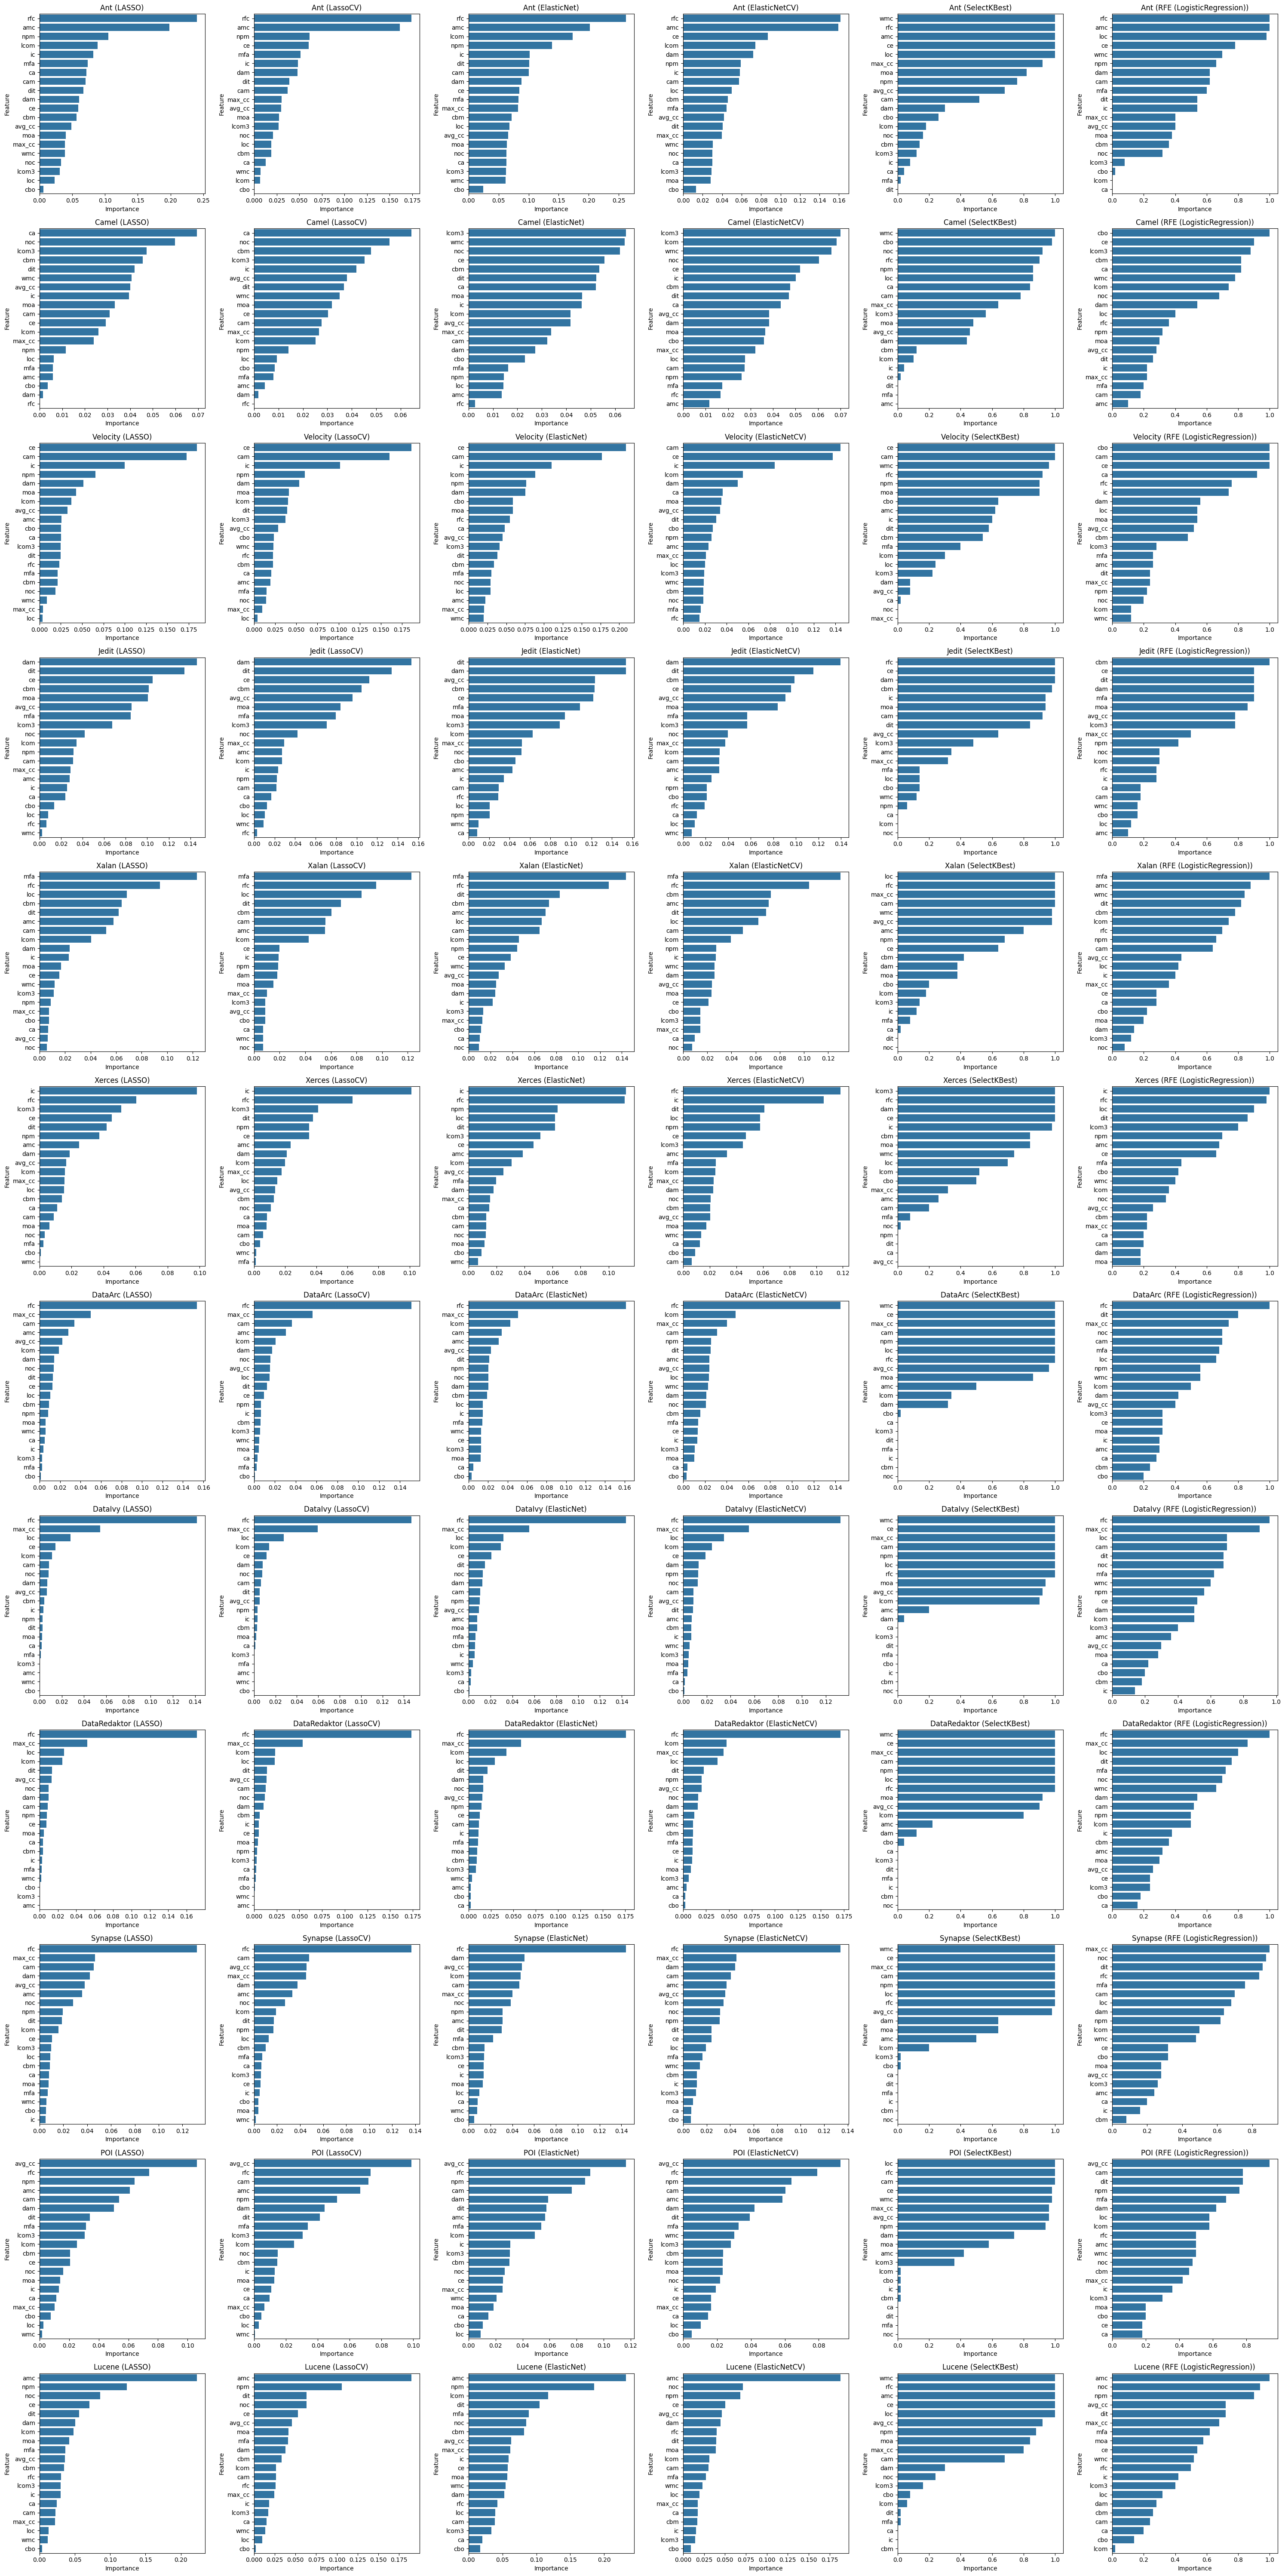

In [86]:
def calculate_stability_kuncheva(Z):
    M, d = Z.shape
    k_bar = np.mean(np.sum(Z, axis=1))
    pairwise_kuncheva = []

    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(np.logical_and(Z[i], Z[j]))
            kuncheva_index = (intersection - (k_bar**2 / d)) / (k_bar - (k_bar**2 / d))
            pairwise_kuncheva.append(kuncheva_index)

    return np.mean(pairwise_kuncheva)

def calculate_stability_and_importance(X, y, model, M=50):
    Z = np.zeros((M, X.shape[1]))
    feature_importances = np.zeros(X.shape[1])

    for i in range(M):
        X_bootstrap, y_bootstrap = resample(X, y, replace=True)
        model.fit(X_bootstrap, y_bootstrap)
        if hasattr(model, 'coef_'):
            selected_features = np.where(model.coef_ != 0)[0]
            feature_importances[selected_features] += np.abs(model.coef_[selected_features])
        elif hasattr(model, 'feature_importances_'):
            selected_features = np.argsort(model.feature_importances_)[-int(0.5 * X.shape[1]):]
            feature_importances += model.feature_importances_
        elif isinstance(model, RFE):
            selected_features = np.where(model.support_)[0]
            feature_importances[selected_features] += 1
        elif isinstance(model, SelectKBest):
            selected_features = np.where(model.get_support())[0]
            feature_importances[selected_features] += 1

        Z[i, selected_features] = 1

    stability_jaccard = np.mean([jaccard_score(Z[i], Z[j], average='binary')
                                 for i in range(M) for j in range(i + 1, M)])
    stability_kuncheva = calculate_stability_kuncheva(Z)

    feature_importances /= M
    return stability_jaccard, stability_kuncheva, feature_importances

results = {}
table_data = []

for dataset_name, (X, y) in datasets.items():
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    dataset_results = {}
    for model_name, model in models.items():
        stability_jaccard, stability_kuncheva, feature_importances = calculate_stability_and_importance(X_scaled, y, model)
        dataset_results[model_name] = {
            'stability_jaccard': stability_jaccard,
            'stability_kuncheva': stability_kuncheva,
            'complexity': dataset_complexities[dataset_name]['score'],
            'importances': feature_importances,
            'feature_names': X.columns
        }
        table_data.append([dataset_name, model_name, stability_jaccard, stability_kuncheva, dataset_complexities[dataset_name]['score']])
    results[dataset_name] = dataset_results

df_table = pd.DataFrame(table_data, columns=['Dataset', 'Model', 'Stability (Jaccard)', 'Stability (Kuncheva)', 'Complexity'])

n_datasets = len(results)
n_models = len(next(iter(results.values())))

fig, axes = plt.subplots(n_datasets, n_models, figsize=(5 * n_models, 5 * n_datasets))

for i, (dataset_name, dataset_results) in enumerate(results.items()):
    for j, (model_name, res) in enumerate(dataset_results.items()):
        feature_importance_df = pd.DataFrame({
            'Feature': res['feature_names'],
            'Importance': res['importances']
        }).sort_values(by='Importance', ascending=False)

        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=axes[i, j])
        axes[i, j].set_title(f'{dataset_name} ({model_name})')
        axes[i, j].set_xlabel('Importance')
        axes[i, j].set_ylabel('Feature')

plt.tight_layout()
plt.show()


# Analysis of Complexity vs. Feature Selection Stability

These plots analyze the relationship between dataset complexity and feature selection stability. The stability is measured using two different indices: Jaccard and Kuncheva. Each line represents how the stability of the feature selection algorithms changes as the complexity of the datasets increases, providing insights into the robustness of the selection process across different levels of dataset complexity.

     Dataset                    Model  Stability (Jaccard)  Stability (Kuncheva)  Complexity
         Ant                    LASSO             0.508691              0.190660       0.316
         Ant                  LassoCV             0.381051              0.242892       0.316
         Ant               ElasticNet             0.657948              0.133423       0.316
         Ant             ElasticNetCV             0.438770              0.168772       0.316
         Ant              SelectKBest             0.682318              0.609633       0.316
         Ant RFE (LogisticRegression)             0.529220              0.369306       0.316
       Camel                    LASSO             0.699295              0.493285       0.440
       Camel                  LassoCV             0.669798              0.460304       0.440
       Camel               ElasticNet             0.727174              0.327707       0.440
       Camel             ElasticNetCV             0.735956            

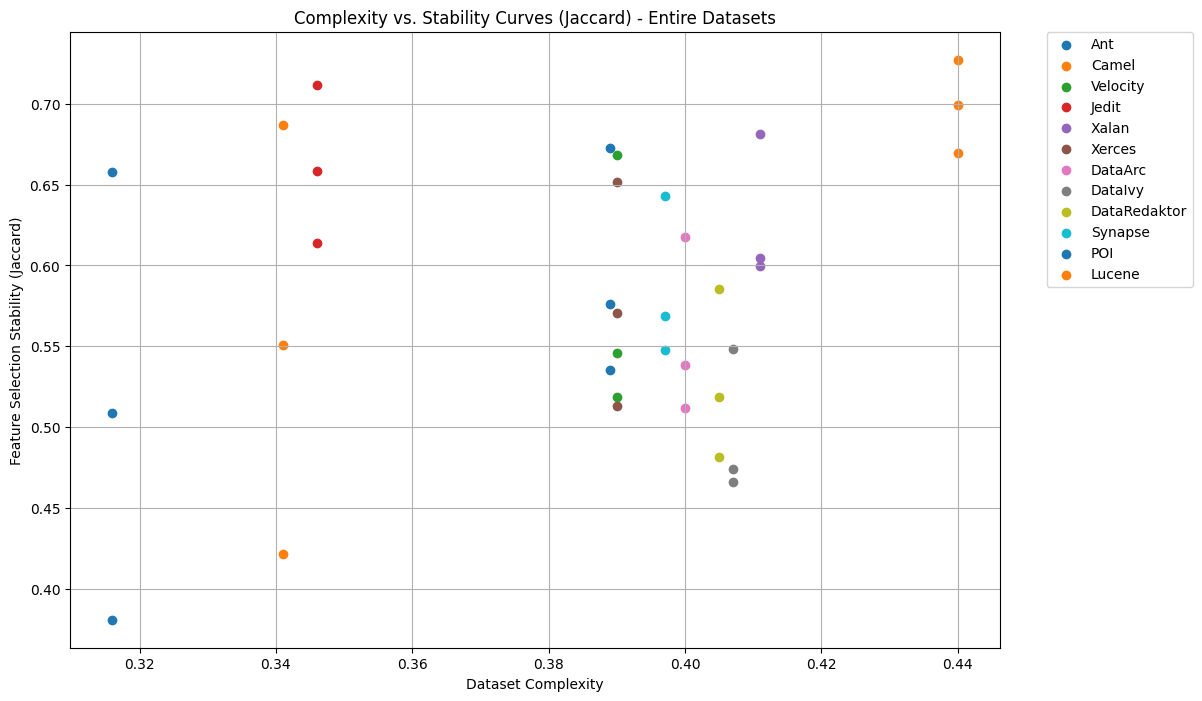

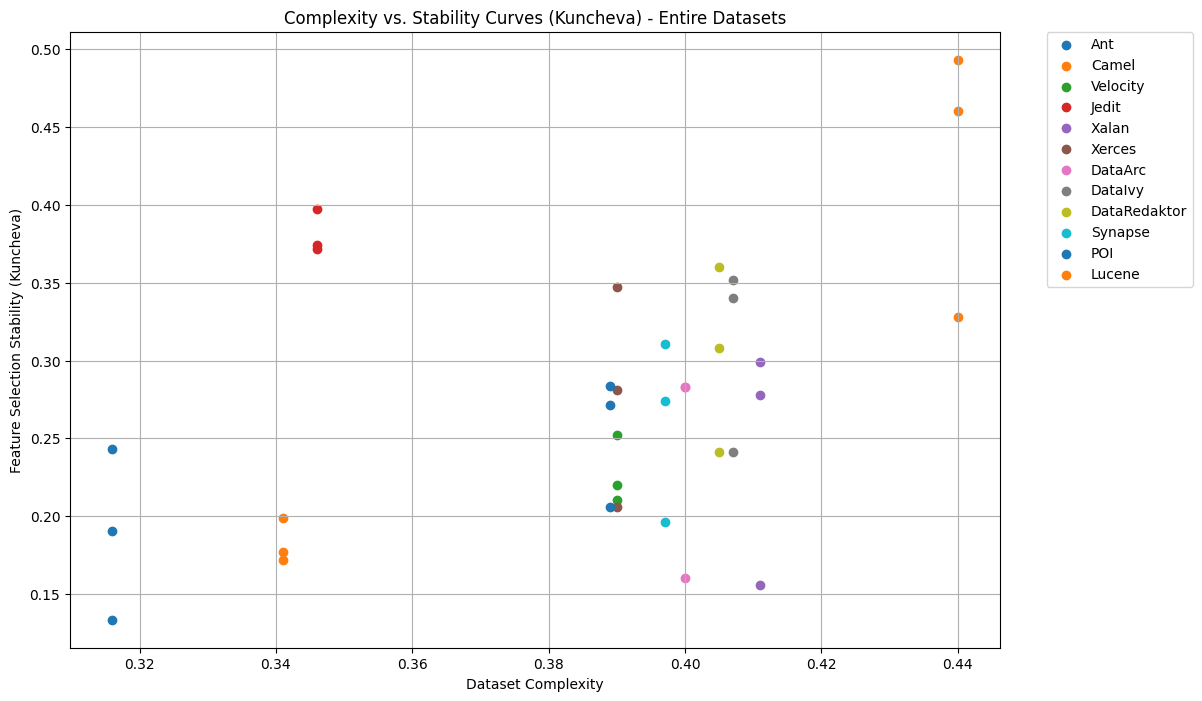

In [129]:
print(df_table.to_string(index=False))
selected_algorithms = ['LASSO', 'LassoCV', 'ElasticNet']
filtered_results = {
    dataset_name: {d_name: d_results
                   for d_name, d_results in dataset_results.items()
                   if d_name in selected_algorithms}
    for dataset_name, dataset_results in results.items()
}

if not selected_algorithms:
    filtered_results = results

plt.figure(figsize=(12, 8))
for dataset_name, dataset_results in filtered_results.items():
    complexities = [res['complexity'] for res in dataset_results.values()]
    stabilities = [res['stability_jaccard'] for res in dataset_results.values()]
    plt.scatter(complexities, stabilities, marker='o', label=dataset_name)

plt.xlabel('Dataset Complexity')
plt.ylabel('Feature Selection Stability (Jaccard)')
plt.title('Complexity vs. Stability Curves (Jaccard) - Entire Datasets')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
for dataset_name, dataset_results in filtered_results.items():
    complexities = [res['complexity'] for res in dataset_results.values()]
    stabilities = [res['stability_kuncheva'] for res in dataset_results.values()]
    plt.scatter(complexities, stabilities, marker='o', label=dataset_name)

plt.xlabel('Dataset Complexity')
plt.ylabel('Feature Selection Stability (Kuncheva)')
plt.title('Complexity vs. Stability Curves (Kuncheva) - Entire Datasets')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()




In [12]:
!jupyter nbconvert --to markdown /content/drive/MyDrive/Colab\ Notebooks/TFM/complexity-stability-selection.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/TFM/complexity-stability-selection.ipynb to markdown
[NbConvertApp] Support files will be in complexity-stability-selection_files/
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/TFM/complexity-stability-selection_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/TFM/complexity-stability-selection_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/TFM/complexity-stability-selection_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/TFM/complexity-stability-selection_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/TFM/complexity-stability-selection_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/TFM/complexity-stability-selection_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/TFM/complexity-stability-selection_files
[NbConvertA